In [46]:
import numpy as np
from PIL import Image
import torch as torch
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import os
from einops import rearrange
from custom_transforms import *
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from monai.transforms import AsDiscrete


class tumor_Dataset(Dataset):
    def __init__(self,path, train=True):
        self.path = path
        self.train = train
        self.train_path_list = []
        self.train_list = []

        self.label_path_list = []
        self.label_list = []

        self.train_path = path + "/input"
        self.label_path = path + "/target"

        
        for file in os.listdir(self.train_path):
            self.train_path_list.append(os.path.join(self.train_path,file))
        self.train_path_list.sort()
                
        for file in os.listdir(self.label_path):
            self.label_path_list.append(os.path.join(self.label_path,file))           
        self.label_path_list.sort()

    def __len__(self):
        return len(self.label_path_list)

    def preprocessing(self,train_path, label_path):

        input_slice = pydicom.read_file(train_path)
        input_img = input_slice.pixel_array
        input_img = apply_voi_lut(input_img, input_slice)
        epsilon = 1e-10
        min_val = np.min(input_img)
        max_val = np.max(input_img)
        input_img = (input_img - min_val) / (max_val - min_val+epsilon)
        input_img = Image.fromarray(input_img)

        target_slice = pydicom.read_file(label_path)
        target_img = target_slice.pixel_array
        epsilon = 1e-10
        min_val = np.min(target_img)
        max_val = np.max(target_img)
        target_img = (target_img - min_val) / (max_val - min_val+epsilon)

        target_img = Image.fromarray(target_img)

        return input_img, target_img

    def __getitem__(self,idx):
        if self.train:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize((512,512)),
                                                customRandomRotate(degrees=180,SEED=idx),
                                                customRandomHorizontalFlip(p=0.5,SEED=idx),
                                                #customRandomResizedCrop(SEED=idx,size=(256,256))
                                                ])
        else:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Resize((512,512))
                                                 ])

        

        image,label = self.preprocessing(self.train_path_list[idx], self.label_path_list[idx])    

        input_image = self.transform((image))
        target_image = self.transform((label))

        threshold = AsDiscrete(threshold=0.5)
        target_image = threshold(target_image)


        return input_image, target_image



In [30]:
import torch
import torch.nn as nn
from tumorSeg_model import tumor_model
from roi_model import ROI_MODEL
device = "cuda:0"
net_path = '/workspace/MR-Segmentation/CHECKPOINT_tumor/LKA_SwinUNetr_231103.pth'
net = tumor_model(img_size=(512,512),spatial_dims=2,in_channels=1,out_channels=1,depths=(2,2,2,2)).to(device=device)
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net,device_ids=[0,1,2,3]) 
net.load_state_dict(torch.load(net_path))



model_path = '/workspace/MR-Segmentation/dir_checkpoint_breast_ROI/ROI_Model_231102.pth'
roi_model = ROI_MODEL(img_size=(512,512),spatial_dims=2,in_channels=1,out_channels=1,depths=(2,2,2,2)).to(device=device)
if torch.cuda.device_count() > 1:
    roi_model = nn.DataParallel(roi_model,device_ids=[0,1,2,3]) 

roi_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [4]:
from monai.transforms import AsDiscrete
import pandas as pd 

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(7777777)


test_excel = pd.read_excel("/mount_folder/test_data.xlsx")
test_list = test_excel["Patient"].tolist()


def evaluate_segmentation(model, roi_model, dataset, test_list, device='cuda:0'):
    # 초기 confusion matrix 요소 값
    TP_total = 0
    FP_total = 0
    FN_total = 0
    TN_total = 0
    threshold = AsDiscrete(threshold=0.5)
    model.eval()
    test_loader = DataLoader(dataset=dataset,batch_size=1,shuffle=False)

    for input_image, true_mask in test_loader:
        input_image = input_image.to(device)
        
        with torch.no_grad():
            roi_preds = torch.sigmoid(roi_model(input_image))
            roi_thresh = threshold(roi_preds)
            roi_results = input_image * roi_thresh

            predicted_mask = model(roi_results)

        predicted_mask = predicted_mask.cpu().numpy()
        true_mask = true_mask.cpu().numpy()

        # 이진 분류를 위한 threshold 적용
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
        
        # 현재 slice에 대한 confusion matrix 요소 계산
        TP = np.sum((predicted_mask == 1) & (true_mask == 1))
        FP = np.sum((predicted_mask == 1) & (true_mask == 0))
        FN = np.sum((predicted_mask == 0) & (true_mask == 1))
        TN = np.sum((predicted_mask == 0) & (true_mask == 0))
        
        # 현재 slice의 결과를 전체 결과에 합산
        TP_total += TP
        FP_total += FP
        FN_total += FN
        TN_total += TN
    
    # 모든 slices를 기반으로 한 Dice Score 계산
    dice = (2 * TP_total) / (2 * TP_total + FP_total + FN_total+1e-10)
    
    return dice



In [49]:
len(test_list)

211

In [31]:
dice_dict = {}
for patient in test_list:
    dataset = tumor_Dataset_testing(path="/mount_folder/Tumors/test",patient=patient, train=False)
    model = net
    dice = evaluate_segmentation(model, roi_model, dataset, test_list, device='cuda:0')
    print(f"{patient} : {dice}")
    dice_dict[f"{patient}"] = dice

1167753 : 0.7633532273433964


In [18]:
values_list = list(dice_dict.values())
print(values_list)  # 출력: [1, 2, 3]

[0.907629412739625, 0.4354327715118434, 0.6274668507629666, 0.7208376963350634, 0.3967041800643047, 0.7276663689751273, 0.7682672233820191, 0.3220953416711952, 0.6960346692995781, 0.8106619756013583, 0.8224187160357354, 0.9047881122729725, 0.8992317541613258, 0.7791984615699336, 0.2967693463561121, 0.30194619347452345, 0.7997202308095793, 0.8477064220183367, 0.7430235994427292, 0.7633532273433964, 0.07006000509695788, 0.803144989339017, 0.6215182960130906, 0.7836986301369809, 0.8128292474079023, 0.7382309096228586, 0.8040383465804662, 0.8981181051265394, 0.027864235956721092, 0.40884902840059667, 0.6151225409385613, 0.8579750052954838, 0.8689001337753729, 0.8901401241282175, 0.8889236790606584, 0.8506117631035338, 0.7629893238434103, 0.7206349206349119, 0.6953002566001331, 0.9191682301438364, 0.7150202976995844, 0.810313075506444, 0.8139607744846151, 0.0, 0.8754127889522535, 0.7254003436854024, 0.19652173913043136, 0.8317113695703675, 0.8153215462387746, 0.7672310212998278, 0.119045568

In [59]:
import SimpleITK as sitk
import torch
import numpy as np


# LabelOverlapMeasuresImageFilter를 사용하여 겹침 측정
def calculate_overlap_measures(truth_image_3d, prediction_image_3d):
    
    truth_image_3d = sitk.Cast(truth_image_3d, sitk.sitkUInt16)
    prediction_image_3d = sitk.Cast(prediction_image_3d,sitk.sitkUInt16)

    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    
    # 필터에 진실 이미지와 예측 이미지 설정
    overlap_measures_filter.Execute(truth_image_3d, prediction_image_3d)
    
    return overlap_measures_filter.GetDiceCoefficient(), overlap_measures_filter.GetJaccardCoefficient()
    
def combine_2d_slices_to_3d_itk(slices):
    # 2D 슬라이스들을 하나의 Numpy 배열로 쌓기
    volume_array = np.stack(slices)
    volume_array = volume_array.squeeze()
    image_3d = sitk.GetImageFromArray(volume_array)
    #image_3d.CopyInformation(reference_image)
    
    return image_3d

In [60]:
dice_dict = {}
jaccard_dict = {}
for patient in test_list:

    test_dataset = tumor_Dataset(path=f"/mount_folder/Tumors/test/{patient}/",train=False)
    test_loader = DataLoader(test_dataset,batch_size = 1, shuffle=False)
    target_dir = f"/mount_folder/Tumors/test/{patient}/target"

    threshold = AsDiscrete(threshold=0.5)

    # 실제 마스크 3D 볼륨으로 로드 (DICOM)
    #itk_truth_3d = load_dicom_slices_as_3d_itk(target_dir)
    # 2D 슬라이스들에 대한 모델 예측을 쌓아 3D 볼륨 만들기
    model_outputs = []
    model_truemasks = []
    for i, (image,true_mask) in enumerate(test_loader):
        image = image.to(device="cuda:0",dtype=torch.float32)
        true_mask = true_mask.to(device="cuda:0",dtype=torch.float32)
        with torch.no_grad():
            roi_preds = torch.sigmoid(roi_model(image))
            roi_thresh = threshold(roi_preds)
            roi_results = image * roi_thresh

            predicted_mask = model(roi_results)
        model_output = threshold(torch.sigmoid(predicted_mask))
        # 결과를 리스트에 추가
        model_outputs.append(model_output.detach().cpu().numpy())
        model_truemasks.append(true_mask.detach().cpu().numpy())

    # 모델 출력 3D 볼륨으로 변환
    itk_pred_3d = combine_2d_slices_to_3d_itk(model_outputs)
    itk_truth_3d = combine_2d_slices_to_3d_itk(model_truemasks)

    # 이미지를 로드하고 겹침 측정 실행
    overlap_measures = calculate_overlap_measures(itk_truth_3d, itk_pred_3d)

    print(f"{patient} dice score : {overlap_measures[0]:.4f}")
    print(f"{patient} jaccard score : {overlap_measures[1]:.4f}")

    dice_dict[f"{patient}"] = overlap_measures[0]
    jaccard_dict[f"{patient}"] = overlap_measures[1]
    


1167753 dice score : 0.9055
1167753 jaccard score : 0.8274
1199340 dice score : 0.4344
1199340 jaccard score : 0.2775
1199440 dice score : 0.6177
1199440 jaccard score : 0.4469
1199470 dice score : 0.7171
1199470 jaccard score : 0.5590
1199870 dice score : 0.3936
1199870 jaccard score : 0.2450
1199940 dice score : 0.7210
1199940 jaccard score : 0.5637
1219657 dice score : 0.7686
1219657 jaccard score : 0.6242
1229070 dice score : 0.3142
1229070 jaccard score : 0.1864
1249647 dice score : 0.7049
1249647 jaccard score : 0.5442
1284590 dice score : 0.8064
1284590 jaccard score : 0.6757
1299050 dice score : 0.8182
1299050 jaccard score : 0.6924
1299690 dice score : 0.9034
1299690 jaccard score : 0.8237
1329450 dice score : 0.8984
1329450 jaccard score : 0.8155
1329490 dice score : 0.7823
1329490 jaccard score : 0.6425
1364554 dice score : 0.3030
1364554 jaccard score : 0.1786
1389134 dice score : 0.3077
1389134 jaccard score : 0.1818
1399050 dice score : 0.7972
1399050 jaccard score : 0.66

In [57]:
dice_list = list(dice_dict.values())
np.mean(dice_list)

0.6443435110200715

In [54]:
# 딕셔너리를 DataFrame으로 변환
df = pd.DataFrame(list(dice_dict.items()), columns=['Patient ID', 'DICE'])

# DataFrame을 Excel 파일로 저장
df.to_excel('/mount_folder/patients_dice_scores.xlsx', index=False)

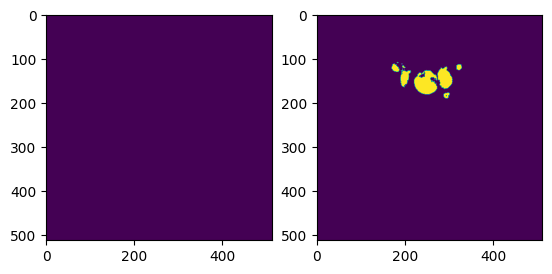

In [26]:
import matplotlib.pyplot as plt
true_mask = sitk.GetArrayFromImage(itk_truth_3d)
pred_img = sitk.GetArrayFromImage(itk_pred_3d)

plt.subplot(1,2,1)
plt.imshow(true_mask[60])
plt.subplot(1,2,2)
plt.imshow(pred_img[60])

In [65]:
import SimpleITK as sitk
import pydicom
import os
import numpy as np

directory = '/mount_folder/Tumors/test/1167753/input' 
# SimpleITK를 이용하여 DICOM 시리즈 읽기
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(directory)
reader.SetFileNames(dicom_names)
images = reader.Execute()